# Guia do Projeto - Tech Challenge Fase 4 - Parte 02

## Detecção Facial com Inteligência Artificial (YOLOv11 Pose)

Nesta segunda etapa, avançamos do processamento de vídeo bruto para a **Visão Computacional**. Nosso objetivo é localizar rostos humanos em cada frame do vídeo.

### Teoria: O que é Detecção Facial?

Detecção Facial é a tarefa de identificar a presença e a localização de rostos em uma imagem. O resultado geralmente é uma **Bounding Box** (caixa delimitadora) definida por coordenadas (x, y, largura, altura).

### Por que escolhemos o YOLOv11 Pose?

Para este projeto, não usamos um detector comum (como Haar Cascades). Escolhemos o **YOLO (You Only Look Once)** na sua versão **Pose**.

1.  **Velocidade (Single-Stage):** O YOLO processa a imagem inteira de uma única vez, sendo extremamente rápido e ideal para vídeos.
2.  **Keypoints (Pontos-Chave):** A versão "Pose" não detecta apenas a caixa. Ela identifica 5 pontos anatômicos do rosto:
    *   Nariz
    *   Olho Esquerdo e Direito
    *   Orelha Esquerda e Direita

**A Vantagem dos Keypoints:**
Saber onde estão os olhos e o nariz nos permite alinhar o rosto antes de analisar a emoção, garantindo muito mais precisão do que apenas recortar um quadrado.

In [1]:
import cv2
import matplotlib.pyplot as plt
import sys
import os
from dataclasses import dataclass
from typing import List, Optional, Generator, Tuple
import numpy as np
from ultralytics import YOLO
import logging

# Configuração de logging para acompanhar o processo
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

### 1. Estrutura de Dados e Classes

Para organizar nosso código, definimos classes que representam os objetos do mundo real com os quais estamos lidando: `BoundingBox` (a caixa) e `FaceDetection` (o resultado da IA).

In [2]:
# --- Modelos de Dados (Data Classes) ---
# Usamos dataclasses para criar estruturas de dados simples e legíveis

@dataclass
class BoundingBox:
    """
    Representa o retângulo que envolve o rosto detectado.
    Coordenadas: (x, y) é o canto superior esquerdo.
    """
    x: int
    y: int
    width: int
    height: int

@dataclass
class FaceDetection:
    """
    Agrupa o resultado da detecção: a caixa e a confiança do modelo.
    Confidence (0.0 a 1.0) indica a certeza da IA de que aquilo é um rosto.
    """
    bounding_box: BoundingBox
    confidence: float

# --- Processador de Vídeo (Reutilizado da Parte 01) ---

class VideoProcessor:
    """
    Gerencia a leitura do vídeo frame a frame.
    (Código idêntico ao notebook anterior para garantir independência)
    """
    def __init__(self, video_path: str):
        if not os.path.exists(video_path):
            raise FileNotFoundError(f"Arquivo de vídeo não encontrado: {video_path}")
        self.video_path = video_path
        self.cap = cv2.VideoCapture(video_path)
        if not self.cap.isOpened():
            raise ValueError(f"Não foi possível abrir o vídeo: {video_path}")
        self.fps = self.cap.get(cv2.CAP_PROP_FPS)
        self.frame_count = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))
        self.width = int(self.cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        self.height = int(self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    def get_frames(self) -> Generator[Tuple[int, float, cv2.Mat], None, None]:
        frame_num = 0
        while True:
            ret, frame = self.cap.read()
            if not ret: break
            timestamp = frame_num / self.fps if self.fps > 0 else 0
            yield frame_num, timestamp, frame
            frame_num += 1

    def release(self):
        self.cap.release()

# --- O Detector Facial Inteligente ---

class FaceDetector:
    """
    Encapsula o modelo YOLOv11 Pose para detectar rostos.
    """
    def __init__(
        self,
        model_path: str = "yolo11n-pose.pt",
        confidence_threshold: float = 0.5,
        keypoint_confidence: float = 0.5
    ):
        """
        Args:
            model_path: Caminho para o arquivo de pesos do modelo (.pt)
            confidence_threshold: Mínimo de certeza para considerar uma detecção válida (0.5 = 50%)
            keypoint_confidence: Mínimo de certeza para cada ponto do rosto (olhos, nariz)
        """
        # Carrega o modelo YOLO pré-treinado
        self.model = YOLO(model_path)
        self.confidence_threshold = confidence_threshold
        self.keypoint_confidence = keypoint_confidence
        print(f"FaceDetector inicializado (Modelo: {model_path})")

    def detect(self, frame) -> List[FaceDetection]:
        """
        Processa um único frame e retorna a lista de rostos encontrados.
        """
        # O YOLO faz a inferência na imagem
        results = self.model(frame, conf=self.confidence_threshold, verbose=False)
        faces = []
        frame_height, frame_width = frame.shape[:2]

        for result in results:
            # Se não detectou keypoints (esqueleto), ignora
            if result.keypoints is None: continue
            
            # Extrai os dados brutos dos keypoints
            keypoints = result.keypoints.data

            for person_keypoints in keypoints:
                # Índices do modelo COCO Pose:
                # 0: Nariz, 1: Olho Esq, 2: Olho Dir, 3: Orelha Esq, 4: Orelha Dir
                nose = person_keypoints[0]
                left_eye = person_keypoints[1]
                right_eye = person_keypoints[2]

                # Filtramos apenas pontos com alta confiança
                face_keypoints = []
                for kp in [nose, left_eye, right_eye]:
                    if kp[2] > self.keypoint_confidence:
                        face_keypoints.append([kp[0].item(), kp[1].item()])

                # Precisamos de pelo menos 2 pontos para estimar o tamanho do rosto
                if len(face_keypoints) >= 2:
                    face_keypoints = np.array(face_keypoints)
                    
                    # Calculamos a caixa que envolve os pontos visíveis
                    x_min = int(face_keypoints[:, 0].min())
                    x_max = int(face_keypoints[:, 0].max())
                    y_min = int(face_keypoints[:, 1].min())
                    y_max = int(face_keypoints[:, 1].max())

                    # --- Padding Dinâmico (Margem de Segurança) ---
                    # Como os pontos são internos (olhos/nariz), a caixa ficaria muito apertada.
                    # Adicionamos uma margem proporcional para incluir testa e queixo.
                    w = x_max - x_min
                    h = y_max - y_min
                    
                    # 70% de margem extra parece ser o ideal para emoções
                    pad_x = int(w * 0.7)
                    pad_y = int(h * 0.7)

                    x_min = max(0, x_min - pad_x)
                    y_min = max(0, y_min - pad_y)
                    x_max = min(frame_width, x_max + pad_x)
                    y_max = min(frame_height, y_max + pad_y)

                    # Confiança média dos pontos detectados
                    avg_conf = np.mean([kp[2].item() for kp in [nose, left_eye, right_eye] if kp[2] > 0])

                    faces.append(FaceDetection(
                        bounding_box=BoundingBox(x=x_min, y=y_min, width=x_max-x_min, height=y_max-y_min),
                        confidence=float(avg_conf)
                    ))
        return faces

### 2. Execução e Visualização

Agora vamos colocar tudo em prática. O código abaixo:
1.  Carrega o vídeo.
2.  Inicializa o detector YOLO.
3.  Lê o frame número 100 (para garantir que já apareceu alguém).
4.  Detecta as faces e desenha as caixas resultantes.

FaceDetector inicializado (Modelo: yolo11n-pose.pt)
Faces detectadas no frame 100: 4


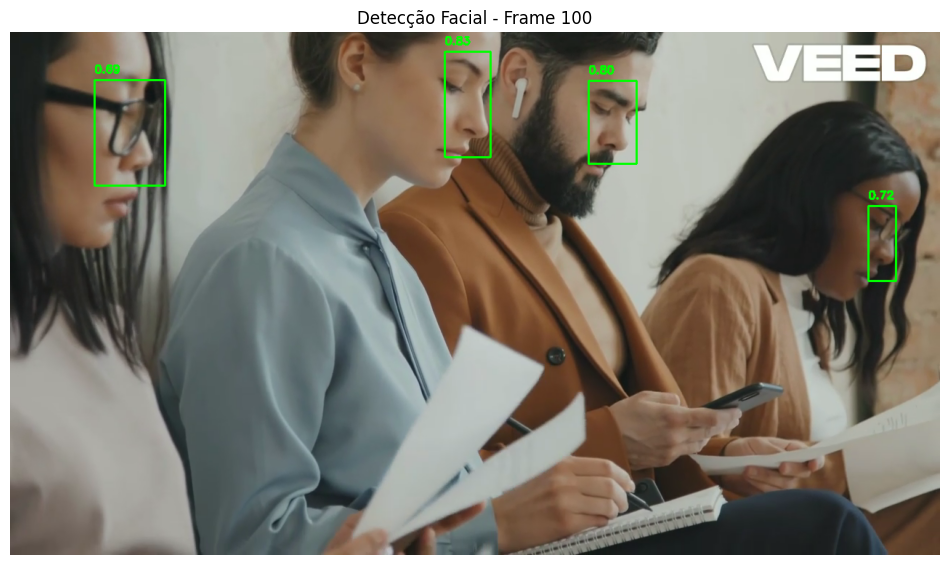

In [3]:
video_path = "meu_video.mp4"

try:
    # Inicializar serviços
    processor = VideoProcessor(video_path)
    detector = FaceDetector(confidence_threshold=0.5)

    # Pular para o frame 100
    target_frame = 100
    current_frame = 0
    selected_frame = None

    for frame_num, ts, frame in processor.get_frames():
        if frame_num == target_frame:
            selected_frame = frame
            break
    
    if selected_frame is not None:
        # Detectar faces
        faces = detector.detect(selected_frame)
        print(f"Faces detectadas no frame {target_frame}: {len(faces)}")

        # Desenhar resultados
        img_viz = selected_frame.copy()
        for face in faces:
            bbox = face.bounding_box
            # Desenha retângulo verde (BGR: 0, 255, 0)
            cv2.rectangle(
                img_viz, 
                (bbox.x, bbox.y), 
                (bbox.x + bbox.width, bbox.y + bbox.height), 
                (0, 255, 0), 
                2
            )
            # Escreve a confiança
            cv2.putText(
                img_viz, 
                f"{face.confidence:.2f}", 
                (bbox.x, bbox.y - 10), 
                cv2.FONT_HERSHEY_SIMPLEX, 
                0.5, 
                (0, 255, 0), 
                2
            )

        # Exibir com Matplotlib (converte BGR para RGB)
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(img_viz, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"Detecção Facial - Frame {target_frame}")
        plt.show()
    else:
        print("Frame não encontrado.")

    processor.release()

except Exception as e:
    print(f"Erro: {e}")

### Conclusão da Parte 02

Agora temos um sistema capaz de "ver" onde estão as pessoas. 

**Destaques Técnicos:**
*   O uso de **Keypoints** (nariz/olhos) permitiu criar caixas de rosto muito mais estáveis do que detectores genéricos.
*   O **Padding Dinâmico** (margem de 70%) foi crucial para garantir que o rosto inteiro (incluindo queixo e testa) seja capturado, o que é vital para a próxima etapa: **Análise de Emoções**.